In [115]:
import numpy as np
from numpy import reshape
import torch
import os
# from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans

In [40]:
NR_SAMPLES=100

In [41]:
# ATTACKS = ['fgsm', 'bim', 'pgd', 'std/8_255', 'df', 'cw']
ATTACKS = ['fgsm', 'bim', 'pgd', 'df', 'cw']

feature_importance = {}

for att in ATTACKS:
    print( att, "===================================")
    clf = torch.load("./../data/detection/run_1/cif10/wrn_28_10_10/" + att + "/LID/k_10/RF/RF.clf".format(0))
    feature_importance[att] = clf.feature_importances_
    print("importance: ", clf.feature_importances_)

fgsm ===================================
importance:  [0.03970159 0.1164327  0.05460795 0.23248282 0.04977856 0.02222687
 0.01826905 0.01606433 0.07101061 0.04927569 0.02524066 0.20949484
 0.09541431]
bim ===================================
importance:  [0.02955799 0.03475442 0.0286254  0.16410419 0.11243226 0.03940012
 0.03982127 0.05078999 0.02344867 0.02273779 0.20062416 0.13804093
 0.11566283]
pgd ===================================
importance:  [0.03173638 0.03236187 0.0310141  0.08702063 0.10729641 0.02518612
 0.03407174 0.04275189 0.02597099 0.02608785 0.18760278 0.20592459
 0.16297466]
df ===================================
importance:  [0.02051114 0.01448017 0.02210592 0.02882424 0.03738294 0.02065742
 0.01983941 0.0212973  0.02006059 0.02469265 0.08401024 0.32819871
 0.35793925]
cw ===================================
importance:  [0.01684195 0.01286017 0.01718254 0.01798074 0.01416154 0.01473228
 0.01533582 0.01777024 0.0197475  0.01993947 0.08075898 0.31859147
 0.4340973 ]


In [42]:
attacks = ['fgsm', 'bim', 'pgd', 'std/8_255', 'df', 'cw']

In [43]:
chars     = torch.load('./../data/extracted_characteristics/run_1/cif10/wrn_28_10_10/std/8_255/LID/characteristics')[:NR_SAMPLES]
chars_adv = torch.load('./../data/extracted_characteristics/run_1/cif10/wrn_28_10_10/std/8_255/LID/characteristics_adv')[:NR_SAMPLES]

y = [np.zeros(NR_SAMPLES)]
characteristics_adv = [chars]

for it, att in enumerate(attacks):
    chars_adv = torch.load('./../data/extracted_characteristics/run_1/cif10/wrn_28_10_10/{}/LID/k_10/characteristics_adv'.format(att))[:NR_SAMPLES]
    characteristics_adv.append(chars_adv)
    
    y.append( np.ones(NR_SAMPLES) * (it ) )

In [44]:
y = [np.zeros(NR_SAMPLES)]

for it in range(len(attacks)):

    y.append( np.ones(NR_SAMPLES) * (it ) )

In [45]:
chars.shape

(100, 13)

In [46]:
chars_adv.shape[0]

100

In [47]:
Y = np.concatenate(y, axis=0)
Y.shape

(700,)

In [48]:
y[1].shape

(100,)

In [49]:
X = np.concatenate(characteristics_adv, axis=0)
X.shape

(700, 13)

In [50]:
tsne = TSNE(n_components=2, random_state=0)

In [51]:
X_2d = tsne.fit_transform(X)

/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [52]:
X_2d.shape

(700, 2)

In [53]:
tsne_result = X_2d
tsne_result_df = pd.DataFrame({'tsne_1': X_2d[:,0], 'tsne_2': X_2d[:,1], 'label': Y})

In [54]:
ATTACKS = ['clean',  'fgsm', 'bim',  'pgd', 'aa', 'df', 'cw']

Text(0.5, 1.0, 't-sne')

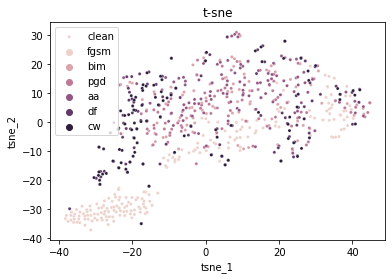

In [55]:
plt.figure()
sc = sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, s=10)
lim = (tsne_result.min()-5, tsne_result.max()+5)
plt.legend(labels=ATTACKS)
plt.title("t-sne")

In [56]:
fig = sc.get_figure()
fig.savefig( 'plots/' + str(NR_SAMPLES) + os.sep + 'cifar10_tsne.png', bbox_inches='tight')

In [57]:
NR_SAMPLES = 100
data_clean = []
data_adv = []

for att in attacks:
    characteristics_pth     = '../data/extracted_characteristics/run_1/cif10/wrn_28_10_10/{}/LID/characteristics'.format(att)
    characteristics_adv_pth = '../data/extracted_characteristics/run_1/cif10/wrn_28_10_10/{}/LID/characteristics_adv'.format(att)
    data_adv.append( torch.load(characteristics_pth)[:NR_SAMPLES] )
    data_clean.append( torch.load(characteristics_adv_pth)[:NR_SAMPLES] )

In [183]:
def create_figure(dat_adv, dat_clean, att='gauss', NR_CLUSTER=5, NR_SAMPLES=100):
    """
    """    
    dict_attacks = {'fgsm' : 0, 'bim': 1, 'pgd': 2, 'aa': 3, 'df': 4, 'cw': 5}
    cdict        = {0: 'black', 1: 'blue', 2: 'red', 3: 'green', 4: 'cyan', 5: 'orange', 6: 'purple'}
    
    X =  np.concatenate( [ dat_clean[ dict_attacks[att] ], dat_adv[ dict_attacks[att] ]  ] , axis=0 )
    Y =  np.concatenate( [ np.ones_like(dat_clean[ dict_attacks[att] ][:,0], dtype=np.int32)*0,  np.ones_like( dat_adv[ dict_attacks[att] ][:,0], dtype=np.int32 ) *1] , axis=0)
    
    print("Y", Y.shape)
    print(Y[:NR_SAMPLES] )
    print(Y[NR_SAMPLES:NR_SAMPLES*2])
    
    tsne = TSNE(n_components=2, random_state=0)
    X_2d = tsne.fit_transform(X)
    
    Kmean = KMeans(n_clusters=NR_CLUSTER)
    Kmean.fit(X_2d)
    y_kmeans = Kmean.predict(X_2d)
    
    fig = plt.figure()
    plt.title( " t-sne , {} samples".format(NR_SAMPLES) )

    # plt.scatter(X[           :NR_SAMPLES,   0], X[          :NR_SAMPLES,   1], label='clean', c=cdict[0]                  , s=10,   marker="v"  )
    # plt.scatter(X[ NR_SAMPLES:NR_SAMPLES*2, 0], X[NR_SAMPLES:NR_SAMPLES*2, 1], label=att,     c=cdict[dict_attacks[att]+1], s=10,   marker="o" )
    
    plt.scatter(X_2d[           :NR_SAMPLES,   0], X_2d[          :NR_SAMPLES,   1], label='clean', c=y_kmeans[:NR_SAMPLES], s=20,   marker="v" )
    plt.scatter(X_2d[ NR_SAMPLES:NR_SAMPLES*2, 0], X_2d[NR_SAMPLES:NR_SAMPLES*2, 1], label=att,     c=y_kmeans[NR_SAMPLES:NR_SAMPLES*2], s=20,   marker="*" )

    # plt.scatter(centroids[0,0], centroids[0,1], s=50,  marker='s', label=labels[1], c=cdict[0]  )
    # plt.scatter(centroids[1,0], centroids[1,1], s=50,  marker='s', label=att, c=cdict[dict_attacks[att]+1]  )
    
    # plt.legend(y_kmeans)
    plt.xlabel("Tsne 0")
    plt.ylabel("Tsne 1")
    
    leg = plt.legend(labelcolor='black')
    LH = leg.legendHandles
    LH[0].set_color('k') 
    LH[1].set_color('k') 
    
    
    return plt

Y (200,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


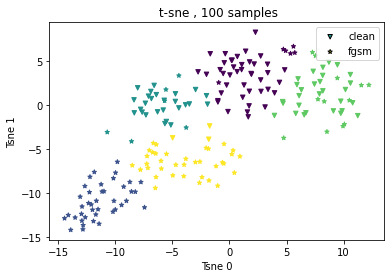

In [184]:
attname = 'fgsm'
plt1 = create_figure(data_adv, data_clean, att=attname, NR_SAMPLES=100)
plt1.savefig("plots/tsne/{}.png".format(attname),  bbox_inches='tight')

Y (200,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


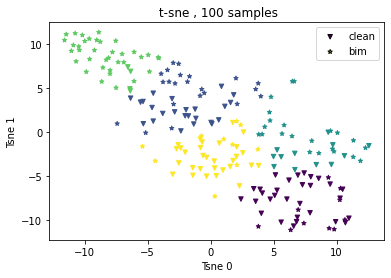

In [185]:
attname = 'bim'
plt1 = create_figure(data_adv, data_clean, att=attname, NR_SAMPLES=100)
plt1.savefig("plots/tsne/{}.png".format(attname),  bbox_inches='tight')

Y (200,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


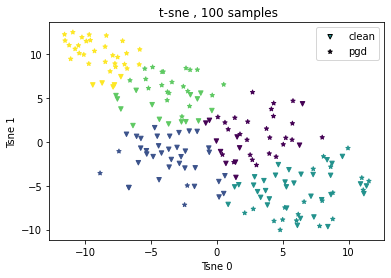

In [186]:
attname = 'pgd'
plt1 = create_figure(data_adv, data_clean, att=attname, NR_SAMPLES=100)
plt1.savefig("plots/tsne/{}.png".format(attname),  bbox_inches='tight')

Y (200,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


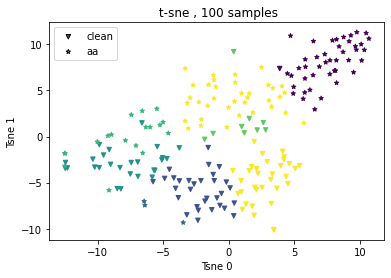

In [187]:
attname = 'aa'
plt1 = create_figure(data_adv, data_clean, att=attname, NR_SAMPLES=100)
plt1.savefig("plots/tsne/{}.png".format(attname),  bbox_inches='tight')

Y (200,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


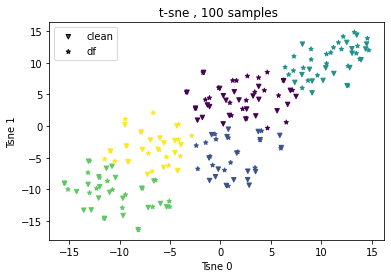

In [188]:
attname = 'df'
plt1 = create_figure(data_adv, data_clean, att=attname, NR_SAMPLES=100)
plt1.savefig("plots/tsne/{}.png".format(attname),  bbox_inches='tight')

Y (200,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lorenzp/.conda/envs/cuda--11-1-1--pytorch--1-9-0/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


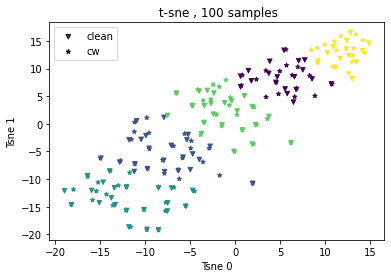

In [189]:
attname = 'cw'
plt1 = create_figure(data_adv, data_clean, att=attname, NR_SAMPLES=100)
plt1.savefig("plots/tsne/{}.png".format(attname),  bbox_inches='tight')